In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os

if not os.path.exists('hello/'):
    os.makedirs('hello/')


In [3]:
data = pd.DataFrame(columns=['hello'])
data.to_csv('hello/')

PermissionError: [Errno 13] Permission denied: 'hello/'

In [2]:
#load the data set of a certain rf
data = pd.read_csv('analog_data/before_hw/powers_fm2_darkcount.csv', index_col = False)

FileNotFoundError: [Errno 2] No such file or directory: 'analog_data/before_hw/powers_fm2_darkcount.csv'

In [28]:
x = data['rotor_step']
y = data['averaged']

Text(0.5, 0, 'Rotor Position [Steps]')

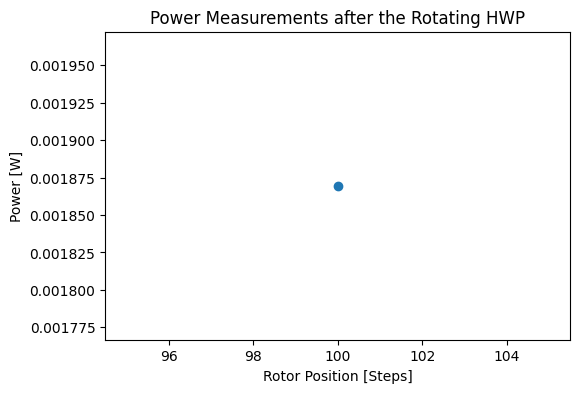

In [36]:
fig, ax = plt.subplots(1,1, figsize =  (6,4))
ax.scatter(x,y)

ax.set_title('Power Measurements after the Rotating HWP')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Rotor Position [Steps]')